# Goals
The purpose of the notebook is to create two annual time series that describe the number of international congresses:
1. hosted in a given country 
1. occurring worldwide

To create these series, this notebook leverages both volumes of the following source: 
* Union of International Associations (UIA). 1960. _Les congrès internationaux, liste complète. International congresses, full list_ [worldcat](https://worldcat.org/title/23419582)


# Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import csv, re, requests, pycountry, os

In [2]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
plt.rcParams["figure.figsize"] = (10,10)
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams['font.sans-serif'] = ['Arial']
plt.rcParams["font.style"] = "normal"
plt.rcParams["axes.labelcolor"] = "gray"
plt.rcParams["text.color"] = "grey"

Directories

In [3]:
DIR = os.path.dirname(os.getcwd()) + "/"
DATA = DIR + "data/"
REFS = DIR + "references/"

# Clean OCRed PDFs

I first used `ocrmypdf` from the command line to OCR both the English and French in the PDF scans located in `references/UIA Congresses`. Then, I used the `tabla`'s GUI to structure the pages into tables and export as a csv. In what follows, I clean up the data in these csvs as a first pass.

In [4]:
til99 = "01_UIA_congresses1899.csv"
til14 = "01_UIA_congresses1914.csv"

## 1800-1889

In [5]:
months =   ['janv.',
            'févri.',
            'mars',
            'avr.',
            'mai',
            'juin',
            'juil.',
            'août',
            'aout',
            'sept.',
            'oct.',
            'nov.',
            'déc.']

In [6]:
with open (DATA + "raw/uia_congresses/" + til99, "r") as f:
    csv_reader = csv.reader(f)
    # ignore top two rows, pre 1800s
    next(csv_reader)
    next(csv_reader)
    year = ""
    years = {}
    for index, row in enumerate(csv_reader):
        broken = ""
        line = " ".join(row).strip()
        no = ""
        # print(line)
        line_tkns = line.split()
        if len(line_tkns) > 0:
            # grab year 
            if len(line_tkns[0]) == 4:
                if line_tkns[0].isdigit() and eval(line_tkns[0]) in range(1800,1914):
                    year = line_tkns[0]
                    if year not in years:
                        years[year] = []
                    # print(year)
            # grab broken line
            if line_tkns[0].islower():                          # NOT CAPTURING DATES ON LINE 2
                broken += " ".join(line_tkns[0:])
                matches = re.findall(r'\d+', broken)
                if len(matches) > 0:
                    broken = broken.split(matches[0])[0].strip()
            # if year not in line_tkns:
            if len(line_tkns) > 1:
                if len(broken) == 0:
                    if line_tkns[0].isdigit():
                        no = line_tkns[0] + " "
                        line_cln = " ".join(line_tkns[1:])
                    else: 
                        no = " "
                        line_cln = " ".join(line_tkns)
                    # print(line_cln)
                    if line_cln[0].isdigit():
                        line_cln_again = ["<nTH>"]
                        line_cln_again.extend(line_cln.split()[1:])
                        line_cln = " ".join(line_cln_again)               
                    matches = re.findall(r'\d+', line_cln)      # CAPTURING CONF. ITERATION
                    if len(matches) > 0:
                        name_place = line_cln.split(matches[0])[0].strip()
                        # print(name_place)
                    else:
                        name_place = line_cln
                    years[year].extend([str(no) + name_place])
                else: 
                    if "-" in years[year][-1]:
                        years[year][-1] = years[year][-1][:-1]
                        years[year][-1] += " " + broken
                    else: 
                        years[year][-1] += " " + broken

In [7]:
with open(DATA + "interim/"+"02_UIA_congresses1899.csv", 'w') as f: 
    csv_writer = csv.writer(f)
    csv_writer.writerow(["year", "congress"])
    for year, congresses in years.items():
        for congress in congresses: 
            csv_writer.writerow([year, congress])

## 1890-1914

In [8]:
with open (DATA + "raw/uia_congresses/" + til14, "r") as f:
    csv_reader = csv.reader(f)
    year = ""
    years = {}
    for index, row in enumerate(csv_reader):
        broken = ""
        line = " ".join(row).strip()
        no = ""
        # print(line)
        line_tkns = line.split()
        if len(line_tkns) > 0:
            # grab year 
            if len(line_tkns) == 1:
                if line_tkns[0].isdigit() and eval(line_tkns[0]) in range(1900,1915):
                    # print(line_tkns[0])
                    year = line_tkns[0]
                    # print(year)
                    if year not in years:
                        years[year] = []
            # grab broken line
            if line_tkns[0].islower():
                broken += " ".join(line_tkns[0:])
                matches = re.findall(r'\d+', broken)
                if len(matches) > 0:
                    broken = broken.split(matches[0])[0].strip()
                # print(broken)
            if len(line_tkns) > 1: 
                if len(broken) == 0:
                    if line_tkns[0].isdigit():
                        no = line_tkns[0] + " "
                        line_cln = " ".join(line_tkns[1:])
                    else: 
                        no = " "
                        line_cln = " ".join(line_tkns)
                    if line_cln[0].isdigit():
                        line_cln_again = ["<nTH>"]
                        line_cln_again.extend(line_cln.split()[1:])
                        line_cln = " ".join(line_cln_again)
                    # print(line_cln)
                    matches = re.findall(r'\d+', line_cln)  
                    # print(matches, line_cln)
                    if len(matches) > 0:
                        name_place = line_cln.split(matches[0])[0].strip()
                        # print(name_place)
                    else:
                        name_place = line_cln
                    years[year].extend([str(no) + name_place])
                    # print(name_place)    
                else: 
                    if len(years[year]) > 0: 
                        if "-" in years[year][-1]:
                            years[year][-1] = years[year][-1][:-1]
                            years[year][-1] += " " + broken
                            # print(lines[year][-1])
                        else: 
                            years[year][-1] += " " + broken
                            # print(lines[year][-1])

In [9]:
with open(DATA + "interim/" + "02_UIA_congresses1914.csv", 'w') as f: 
    csv_writer = csv.writer(f)
    csv_writer.writerow(["year", "congress"])
    for year, congresses in years.items():
        for congress in congresses: 
            csv_writer.writerow([year, congress])

## Manually clean data
* The data outputted above is still messy: conference indices are mis-recognized, dates are still in the conference/congress name, and some rows are even missed altogether. *
* So, by hand, I cross-referenced the CSV with the PDF of the original source and I fixed any incongruencies.

In [10]:
congresses99 = pd.read_csv(DATA + "interim/" + "03_UIA_congresses1899.csv")
congresses14 = pd.read_csv(DATA + "interim/" + "03_UIA_congresses1914.csv")

## Find country host of conferences
To do this, we'll follow these steps: 
1. Look up city's alpha2 code using geonames
1. Convert alpha2 code to alpha3 code using pycountry
1. Look up VDEM country name of alpha3 codes

### Grab Congress ID

In [11]:
congresses99["id"] = congresses99['congress'].apply(lambda x: x.split()[0].strip())
congresses14["id"] = congresses14['congress'].apply(lambda x: x.split()[0].strip())

### Grab City

In [12]:
def get_city(s):
    city = s.split()[-1]
    if city in months:
        city = s.split()[-2]
    else: 
        return city

In [13]:
congresses99['city'] = congresses99['congress'].apply(get_city)
congresses14['city'] = congresses14['congress'].apply(get_city)

### Create dict of all observed cities
This way, we don't inefficiently look up a city hundreds of times.

In [14]:
# Create dict from pandas col, with cities as keys
cities99 = dict.fromkeys(congresses99['city'])
cities14 = dict.fromkeys(congresses14['city'])

# Drop None keys
cities99.pop(None)
cities14.pop(None)

# Drop misrecognized 
cities99.pop("le")

# Combine for whole century 
all_cities = list(cities99.keys())
all_cities.extend(list(cities99.keys()))
all_cities = dict.fromkeys(all_cities)

### Create dictionary of VDEM country names and alpha3 codes.
Since VDEM has all the country-year data, we'll use its country names for the cities>

In [15]:
# Read in VDEm countries and alpha3 codes
vdem_countries = pd.read_csv(DATA + "raw/Country_Year_V-Dem_Full+others_CSV_v12/V-Dem-CY-Full+Others-v12.csv",
                        usecols=["country_name", "country_text_id"])

# Drop duplicates
vdem_countries = vdem_countries.drop_duplicates()

# Convert into a dict
vdem_countries = dict(zip(vdem_countries['country_text_id'], vdem_countries["country_name"]))

### Look up the country of each city
We'll put the each city's country as its value in the `all_cities` dict.

In [16]:
for city in all_cities:
    # look up city using geooname advance search
    # featureClass "P" means city
    response = requests.request("GET", f"https://www.geonames.org/advanced-search.html?q={city}&country=&featureClass=P")
    try:
        # geonames gives just 2-letter name; 
        # convert to 3-letter abbrev to link to VDEM states
        country_alpha2 = re.findall("/countries.*\.html", response.text)[0].split(".")[0].split("/")[2]
        country_alpha3 = pycountry.countries.get(alpha_2=country_alpha2).alpha_3
        all_cities[city] = vdem_countries[country_alpha3]
    except: 
        try:
            # look up city generically, since a few confs/congs only report country
            reponse = response = requests.request("GET", f"https://www.geonames.org/search.html?q={city}")
            country_alpha2 = re.findall("/countries.*\.html", response.text)[0].split(".")[0].split("/")[2]
            country_alpha3 = pycountry.countries.get(alpha_2=country_alpha2).alpha_3
            all_cities[city] = vdem_countries[country_alpha3]
        except:
            # give up; report weird countries
            print("country not found:", city, country_alpha3)
            all_cities[city] = None

country not found: Monaco MCO


### Retrieve country of each conference based on its city
We'll create a new column for the country. It will be list-wise populated by returning the country of the city that appears in the city column using the `all_cities` dict we created above.

In [17]:
# use dict to generate key in country in df
congresses99['state'] = congresses99['city'].apply(lambda x: all_cities[x] if x in all_cities else None)
congresses14['state'] = congresses14['city'].apply(lambda x: all_cities[x] if x in all_cities else None)

In [18]:
congresses14.head()

,year,congress,id,city,state
0,1900,1 Cng I de la marine marchande Paris,1,Paris,France
1,1900,2 Cng I des cuisiniers Stuttgart,2,Stuttgart,Germany
2,1900,3 <nTH> Cng I d’archéologie chrétienne Rome,3,Rome,Italy
3,1900,4 Cnf I pour la protection des ani maux en Afr...,4,Londres,United Kingdom
4,1900,5 <nTH> Cng I des sciences de lécriture Paris,5,Paris,France


# Get Subject Headings of All Congresses from Index

## Read in index
The index organizes conferences and congresses IDs under social scientific / reform subject headings. I created this CSV by hand. It contains the following features:
- `heading` - str the subject headng of the conference that appears in the index
- `til99` - list of the IDs of congs/confs, 1800–1899
- `til14` — list the IDs of congs/congs, 1900–1914
- `sci` — int where `1` = social science; `0` = reformist (progress-, justice-oriented initiatives)

In [19]:
def clean_index(s):
    # The indicies have white space, misrecongized commas
    # and are packaged as list-like strings. This returns
    # a cleaned version.
    s_clean = [i.replace("\n", "").strip() for i in s.replace(".", ",").strip().split(',') if i != ""]
    return s_clean

In [20]:
clean_index("3 ,")

['3']

In [21]:
clean_index(" 604.234")

['604', '234']

Create two dicts for each period, where the key is the conference ID, and it has two values: its subject and whether it's scientific or reformist

In [22]:
with open(DATA + "raw/uia_congresses/" + "UIA_congresses_index.csv", "r") as f: 
    reader = csv.reader(f)
    next(reader)  # ignore field names
    til99_is = {}
    til14_is = {}
    for row in reader:
        heading = row[0]
        is_til99 = clean_index(row[1])
        is_til14 = clean_index(row[2])
        sci = row[3]
        for conference_i in is_til99:
            if conference_i not in til99_is:
                til99_is[conference_i] = [[], None]
            til99_is[conference_i][0].append(heading)
            til99_is[conference_i][1] = sci
        for conference_i in is_til14:
            if conference_i not in til14_is:   
                til14_is[conference_i] = [[], None]
            til14_is[conference_i][0].append(heading)
            til14_is[conference_i][1] = sci       

In [23]:
def lookup_subject(s, dct):
    """ 
    Takes a str of the conf id and the index dict,
    Returns a string of its subjects.
    """
    if s in dct: 
        return " ".join(dct[s][0])
    else:
        return None
    
def lookup_indicator(s, dct):
    """
    Takes a string of the cong id and the index dict,
    Returns int of indicating if scientific `1` or reformist `0`
    """
    if s in dct: 
        return dct[s][1]
    else:
        return None

In [24]:
congresses99['subject'] = congresses99['id'].apply(lambda x: lookup_subject(x, til99_is))
congresses99['scientific_reformist'] = congresses99['id'].apply(lambda x: lookup_indicator(x, til99_is))

congresses14['subject'] = congresses14['id'].apply(lambda x: lookup_subject(x, til14_is))
congresses14['scientific_reformist'] = congresses14['id'].apply(lambda x: lookup_indicator(x, til14_is))

In [25]:
all_congresses = pd.concat([congresses99, congresses14])

In [26]:
all_congresses

,year,congress,id,city,state,subject,scientific_reformist
0,1815,2 Cng des sciences physiques et naturelles Genève,2,Genève,Switzerland,None,None
1,1838,3 Cng celtique I Abergavenny,3,Abergavenny,United Kingdom,None,None
2,1839,4 Réunion des naturalistes scandi naves Goten...,4,Gotenburg,Sweden,None,None
3,1840,5 Réunion des naturalistes scandi naves Copenh...,5,Copenhague,Denmark,None,None
4,1840,6 Convention antiesclavagiste mnd Londres,6,Londres,United Kingdom,Slavery (Anti),0
...,...,...,...,...,...,...,...
2283,1914,2440 Ass des chefs des offices hydro graph. de...,2440,Berne,Switzerland,None,None
2284,1914,2441 Cng I des étudiants de PAmeérique du Sud ...,2441,Santiag,None,Students,1
2285,1914,2442 <nTH> Cng I espérantiste Paris,2442,Paris,France,Esperantists,0
2286,1914,2443 <nTH> Cng des médecins aliénistes et neur...,2443,Luxembourg,Luxembourg,None,None


Select only scientific / reformist congresses

In [27]:
sci_ref_congresses = all_congresses[(all_congresses['scientific_reformist'] == "1") | (all_congresses['scientific_reformist'] == "0")]
sci_ref_congresses

,year,congress,id,city,state,subject,scientific_reformist
4,1840,6 Convention antiesclavagiste mnd Londres,6,Londres,United Kingdom,Slavery (Anti),0
6,1843,8 Convention antiesclavagiste mnd Londres,8,Londres,United Kingdom,Slavery (Anti),0
7,1843,9 Cnf scandinave d’étudiants Uppsala,9,Uppsala,Sweden,Students,1
8,1843,10 Cng I de la Paix Londres,10,Londres,United Kingdom,Peace,0
10,1845,12 Cnf scandinave d’étudiants Copenhague,12,Copenhague,Denmark,Students,1
...,...,...,...,...,...,...,...
2265,1914,2418 <nTH> Cnf I de la Fed abolitionniste Port...,2418,Portsmouth,None,Abolitionism,0
2269,1914,2423 <nTH> Cnf triennale pour les aveugles Lon...,2423,Londres,United Kingdom,Blind Persons,0
2272,1914,"2426 Ass Gén de l’Asn Gén des ingé nieurs, arc...",2426,Lyon,France,"Health, Municipal",1
2284,1914,2441 Cng I des étudiants de PAmeérique du Sud ...,2441,Santiag,None,Students,1


In [28]:
sci_ref_congresses.shape[0] / all_congresses.shape[0]

0.2867189613199892

In [29]:
sci_congresses = all_congresses[(all_congresses['scientific_reformist'] == "1")]
sci_congresses

,year,congress,id,city,state,subject,scientific_reformist
7,1843,9 Cnf scandinave d’étudiants Uppsala,9,Uppsala,Sweden,Students,1
10,1845,12 Cnf scandinave d’étudiants Copenhague,12,Copenhague,Denmark,Students,1
15,1847,18 Cng I des économistes Bruxelles,18,Bruxelles,Belgium,Economists,1
28,1853,32 Cng général de statistique Bruxelles,32,Bruxelles,Belgium,Statistics,1
32,1855,36 Cng I de statistique Paris,36,Paris,France,Statistics,1
...,...,...,...,...,...,...,...
2232,1913,2382 <nTH> Cng I du bureau I des fed nat du pe...,2382,Gand,Belgium,Teachers Teaching,1
2239,1914,2391 <nTH> Cng Cmsn I de l’enseignement mathém...,2391,Paris,France,Teaching,1
2255,1914,2407 Cng I d’ethnologie et d’ethnogra phie Neu...,2407,Neuchatel,None,Ethnography Ethnology,1
2272,1914,"2426 Ass Gén de l’Asn Gén des ingé nieurs, arc...",2426,Lyon,France,"Health, Municipal",1


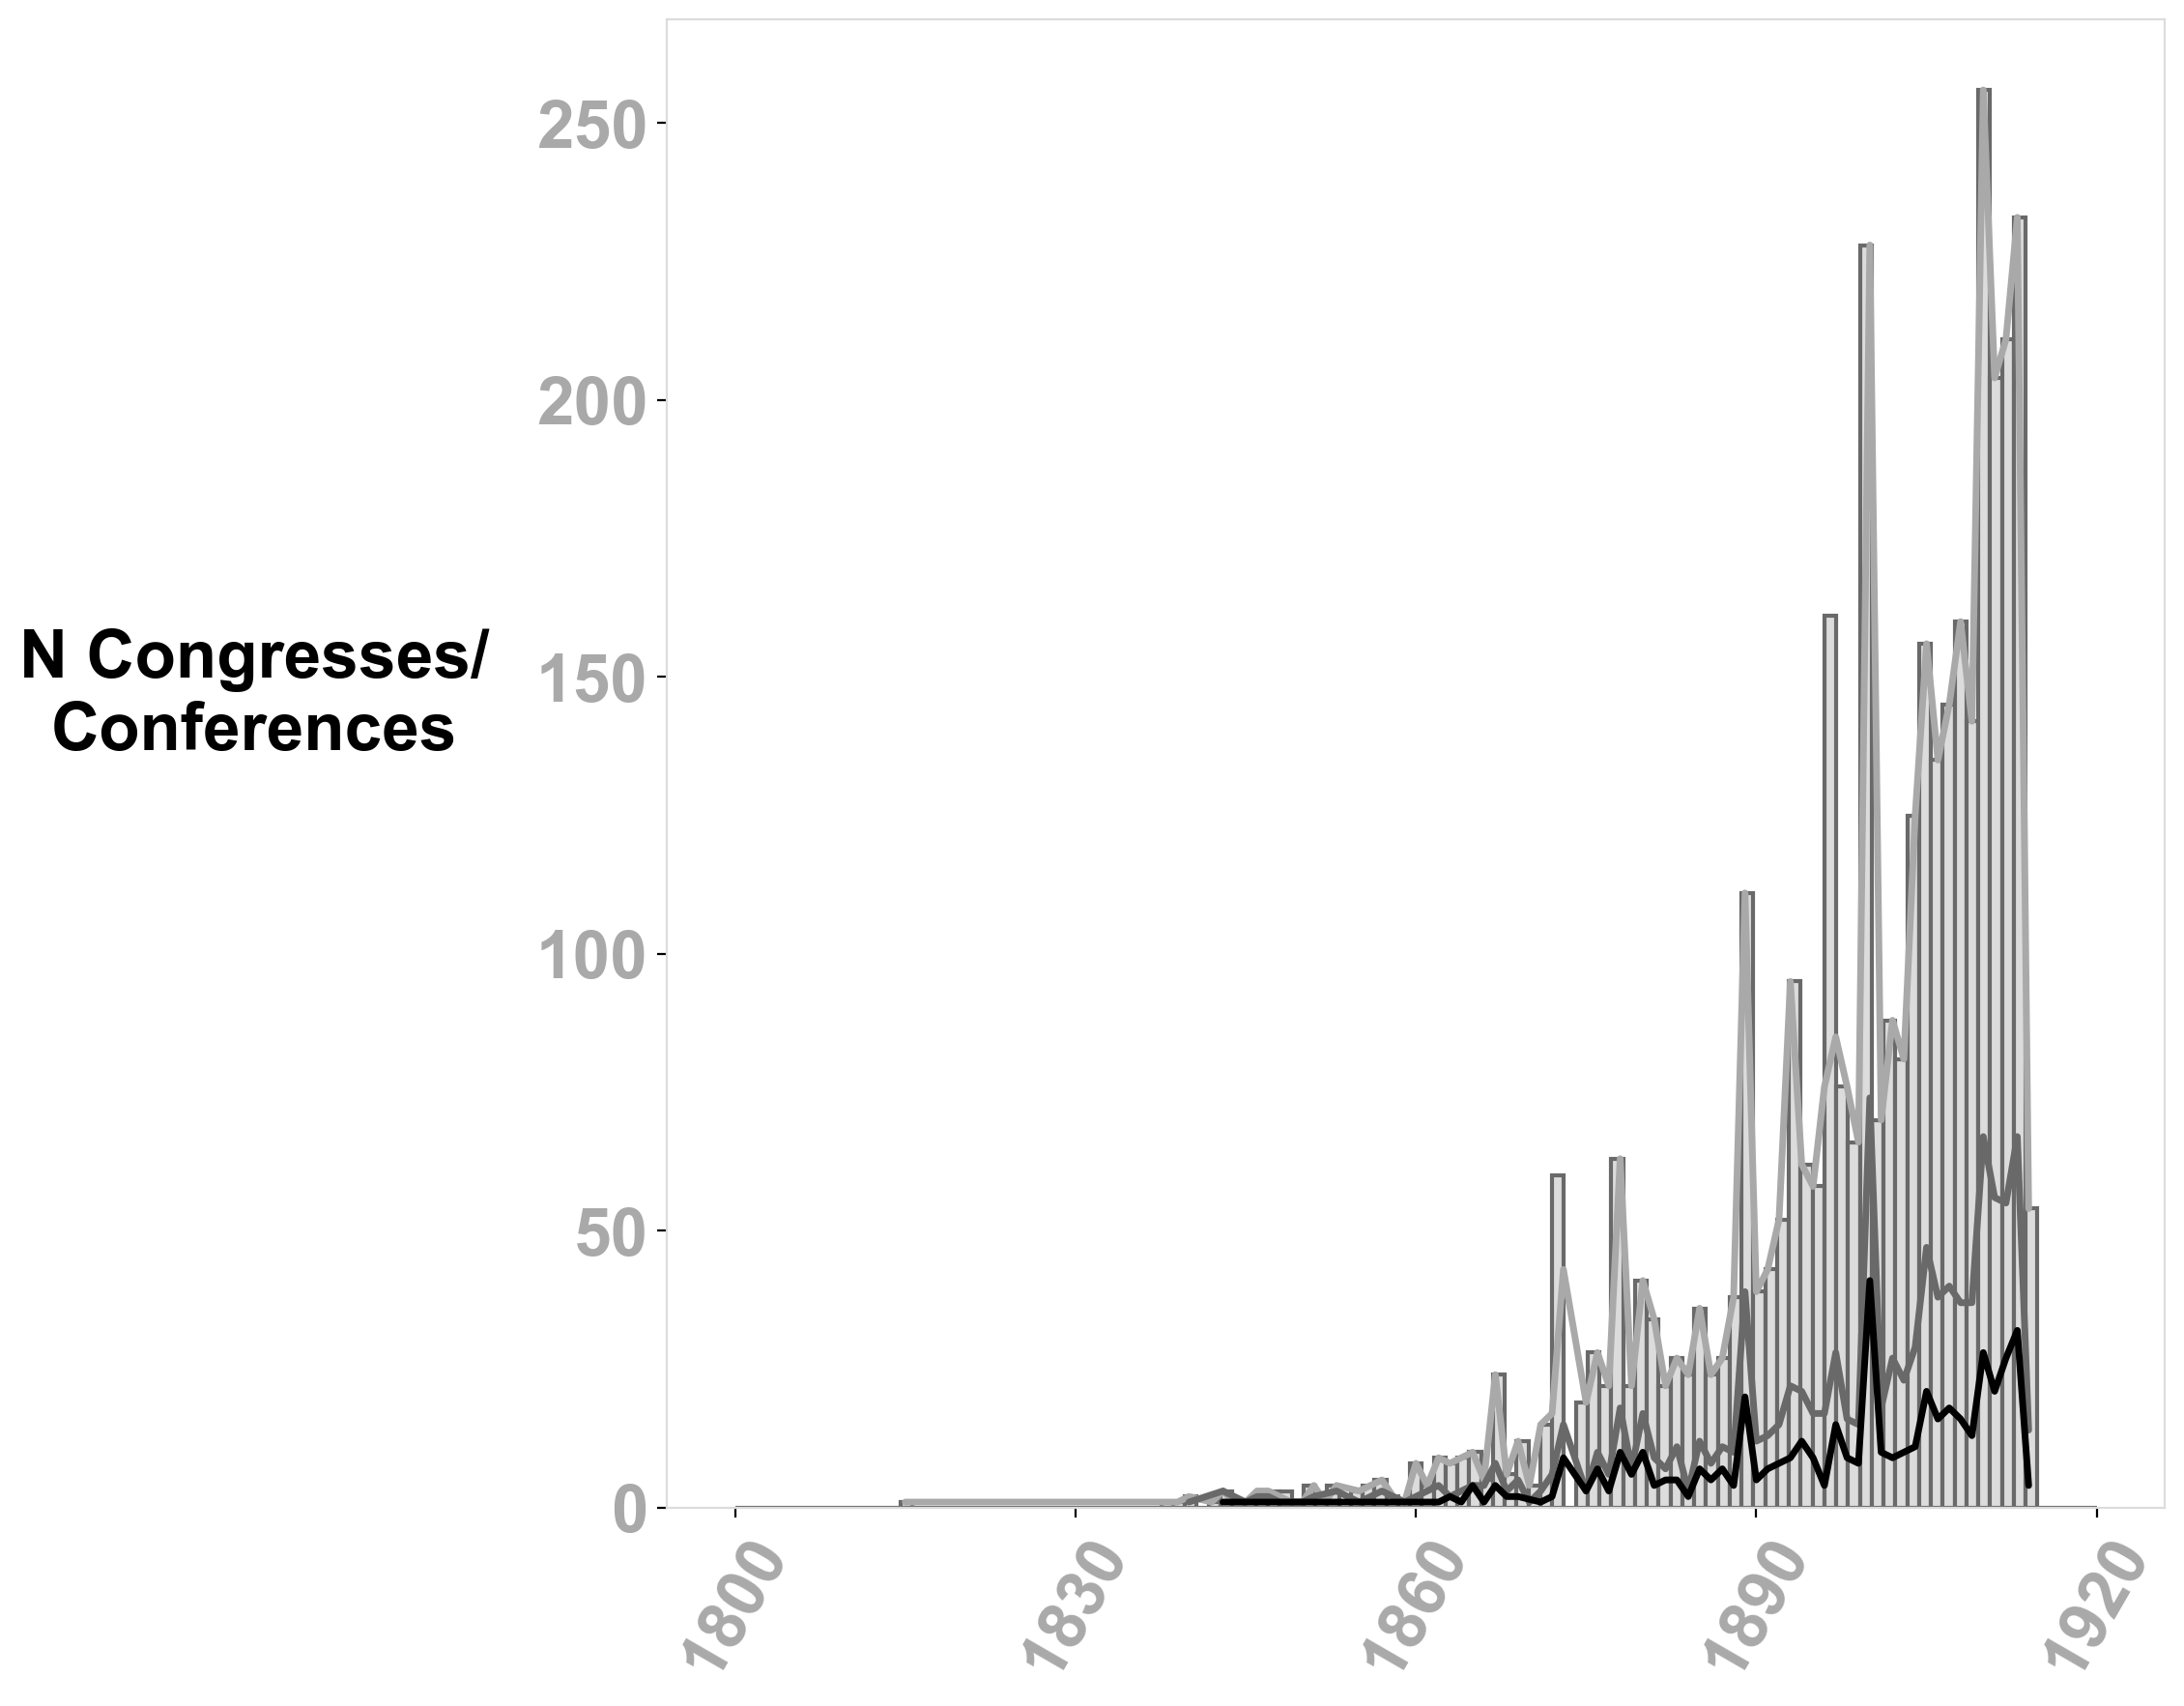

In [30]:
title_color, tick_color, edge_color, data_color = 'black', 'darkgray', 'dimgray', 'gainsboro'
font_size = 25
font_weight = "bold"

fig, ax = plt.subplots()
plt.style.use('seaborn-white')
plt.setp(ax.spines.values(), color=data_color)

plt.hist(sorted(all_congresses['year']), 
         bins=115,
         range=[1800,1920],
         edgecolor=edge_color, 
         facecolor=data_color, 
         linewidth=1.5)


plt.plot(all_congresses.groupby('year').count().index, 
         all_congresses.groupby('year').count()['congress'],  
         linewidth=2.5,
         color=tick_color, scaley=False)

plt.plot(sci_ref_congresses.groupby('year').count().index, 
         sci_ref_congresses.groupby('year').count()['congress'],  
         linewidth=2.5, 
         color=edge_color)

plt.plot(sci_congresses.groupby('year').count().index, 
         sci_congresses.groupby('year').count()['congress'],  
         linewidth=2.5, 
         color=title_color)

# plt.xlabel('N Tokens per Review Comment', 
#            fontsize=font_size, 
#            labelpad=25, 
#            color=title_color, 
#            weight=font_weight)

plt.ylabel('N Congresses/\nConferences', 
           fontsize=font_size, 
           rotation=0,
           labelpad=105, 
           color=title_color, 
           weight=font_weight)

# plt.grid(color=tick_color, 
#          axis="y", 
#          alpha=0.8, 
#          linestyle=':', 
#          linewidth=1)

plt.xticks(ticks=list(range(1800, 1921, 30)),
           fontsize=25, 
           color=tick_color, 
           weight=font_weight,
           rotation = 60)

plt.yticks(ticks=list(range(min(all_congresses.groupby('year').count()['congress'])-1, 
                            max(all_congresses.groupby('year').count()['congress']), 50)),
           fontsize=25, 
           color=tick_color, 
           weight=font_weight)

plt.show()

# Convert to country-year dataset

In [31]:
country_years = {}
for country, country_df in all_congresses.groupby('state'):
    if country not in country_years: 
        country_years[country] = {}
    for year, country_year_df in country_df.groupby("year"):
        if year not in country_years[country]:
            country_years[country][year] = []
        yr_total_cong = country_year_df.shape[0]
        yr_sci_ref_cong = country_year_df[(country_year_df['scientific_reformist'] == "1") | 
                                  (country_year_df['scientific_reformist'] == "0")].shape[0]
        sci_cong = country_year_df[(country_year_df['scientific_reformist'] == "1")].shape[0]
        country_years[country][year].extend([yr_total_cong, yr_sci_ref_cong, sci_cong])

with open(DATA + "interim/" + "19c_congresses_cy.csv", 'w') as f: 
    writer = csv.writer(f)
    writer.writerow(["year", "state", "n_confs_ttl", "n_confs_sci_ref", "n_confs_sci"])
    for year in range(1800, 1914, 1):
        writer.writerow([year, "Finland", 0, 0, 0])
        for country, years in country_years.items():
            if year in years: 
                row = [year, country, years[year][0], years[year][1], years[year][2]]
                writer.writerow(row)
            else:
                row = [year, country, 0, 0, 0]
                writer.writerow(row)

In [33]:
with open(DATA + "interim/" + "19c_congresses_wy.csv", "w") as f: 
    writer = csv.writer(f)
    writer.writerow(["year", "yr_n_cnfs_ttl", "yr_n_cnfs_sci_ref", "yr_n_cnfs_sci"])
    for year, year_df in all_congresses.groupby("year"):
        n_confs_ttl = year_df.shape[0]
        n_cnfs_sci_ref = year_df[year_df['scientific_reformist'] == "0"].shape[0]
        n_cnfs_sci = year_df[year_df['scientific_reformist'] == "1"].shape[0]
        writer.writerow([year, n_confs_ttl, n_cnfs_sci_ref, n_cnfs_sci])